# LGD & EAD & EL Model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import scipy.stats as stat
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score
sns.set_theme(style = 'darkgrid')

In [3]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')

In [4]:
loan_data_preprocessed = loan_data_preprocessed_backup.copy()

In [5]:
loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off', 
                                                                                       'Does not meet the credit policy. Status:Charged Off'])]

In [6]:
loan_data_defaults.shape

(43236, 209)

In [7]:
loan_data_defaults.isnull().sum()

Unnamed: 0.1             0
Unnamed: 0               0
id                       0
member_id                0
loan_amnt                0
                        ..
addr_state:WV            0
addr_state:WY            0
initial_list_status:f    0
initial_list_status:w    0
good_bad                 0
Length: 209, dtype: int64

### Independent Variables

In [8]:
def fill_na_wtih_0(dataset, cols):
    for col in cols:
        dataset.loc[:, col] = dataset[col].fillna(0)

In [9]:
# The two columns that include null values but we need to use in our model
cols_tofill = ['mths_since_last_delinq', 'mths_since_last_record']

fill_na_wtih_0(loan_data_defaults, cols_tofill)

In [10]:
loan_data_defaults['mths_since_last_delinq'].isnull().sum()

0

## Dependent Variables Preprocessing for LGD & EAD Models

### Loss given Default (LGD)

In [11]:
# Ratio of recoveries and funded amount.
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']

In [12]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: recovery_rate, dtype: float64

```
Since the recovery_rate should be around 0 and 1, the max value is greater than 1, so we need to cast the values outside this range to either 0 or 1
```

In [13]:
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, 
                                               np.where(loan_data_defaults['recovery_rate'] > 1, 1,loan_data_defaults['recovery_rate']))

In [14]:
loan_data_defaults['recovery_rate'].describe()

count    43236.000000
mean         0.060770
std          0.089202
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.000000
Name: recovery_rate, dtype: float64

### Exposure at Default (EAD)

In [15]:
# Create credit conversion factor(CCF), 
# the difference of the amount used at the moment of default to the total funded amount.

loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']

In [16]:
loan_data_defaults['CCF'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: CCF, dtype: float64

In [17]:
loan_data_defaults.to_csv('loan_data_defaults.csv')

## Explore Dependent Variables for LGD Model

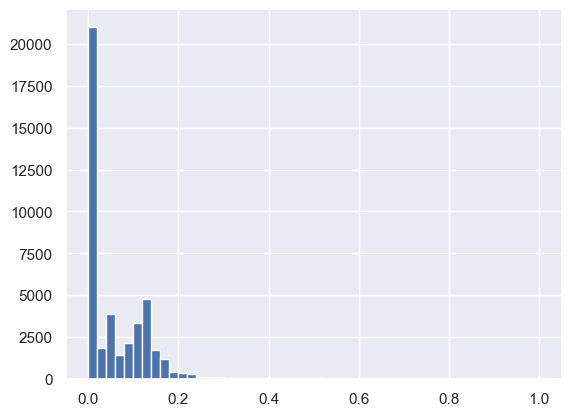

In [18]:
plt.hist(loan_data_defaults['recovery_rate'], bins = 50)
plt.show()

```
The histogram shows that most of the recovery rates are 0, with a small portion greater than 0.

We will use Logistic Regression to predict if the recovery rate is 0, and Linear Regression to estimate the amount when it's greater than 0. Since we cannot use the Beta regression in Python
```

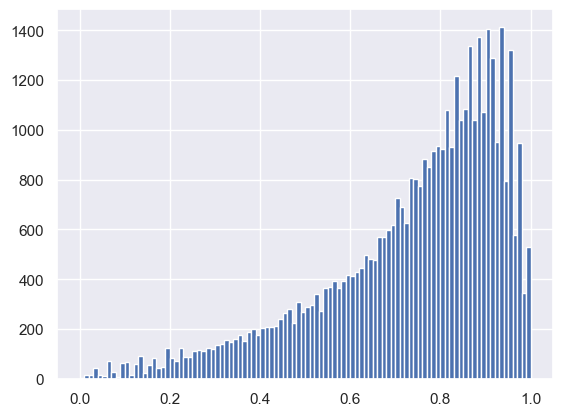

In [19]:
plt.hist(loan_data_defaults['CCF'], bins = 100)
plt.show()

```
The distribution of CCF appears relatively homogeneous, so we will apply Linear Regression.
```

## LGD Model

In [20]:
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)

In [21]:
loan_data_defaults['recovery_rate_0_1'].describe()

count    43236.000000
mean         0.563674
std          0.495935
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: recovery_rate_0_1, dtype: float64

In [22]:
# Splitting Data
lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(
    ['good_bad', 'recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

### Preparing the inputs

In [23]:
# The independent variable that we need (Predictor for LGD model)
all_feature = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:MORTGAGE',
'home_ownership:NONE',
'home_ownership:OTHER',
'home_ownership:OWN',
'home_ownership:RENT',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:car',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:educational',
'purpose:home_improvement',
'purpose:house',
'purpose:major_purchase',
'purpose:medical',
'purpose:moving',
'purpose:other',
'purpose:renewable_energy',
'purpose:small_business',
'purpose:vacation',
'purpose:wedding',
'initial_list_status:f',
'initial_list_status:w',
'term_int',
'emp_length_int',
'mths_since_issue_d',
'mths_since_earliest_cr_line',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

In [24]:
# The most apporiate reference categories
features_reference_cat = ['grade:G',
'home_ownership:RENT',
'verification_status:Verified',
'purpose:credit_card',
'initial_list_status:f']

In [25]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[all_feature]

In [26]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1)

### Estimating the Model

In [27]:
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        # Get p-values for the fitted model
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X) # Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) # Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] # two tailed test for p-values
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [28]:
reg_lgd_st_1 = LogisticRegression_with_p_values()
reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

In [29]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [30]:
def create_summary_table(dataset, model, model_name = None):
    summary_table = pd.DataFrame(columns = ['Feature name'], data = dataset)
    summary_table['Coefficients'] = np.transpose(model.coef_)
    summary_table.index += 1
    summary_table.loc[0] = ['Intercept', model.intercept_]
    summary_table = summary_table.sort_index()
    if model_name == 'Logistic':
        p_values = model.p_values
    elif model_name == 'Linear':
        p_values = model.p
    p_values = np.append(np.nan, np.array(p_values))
    summary_table['p_values'] = p_values
    return summary_table

In [31]:
create_summary_table(feature_name, reg_lgd_st_1, 'Logistic')

,Feature name,Coefficients,p_values
0,Intercept,[-9.392021709261994e-05],NaN
1,grade:A,-0.000011,9.998914e-01
2,grade:B,-0.000072,9.991548e-01
3,grade:C,-0.000142,9.982816e-01
4,grade:D,0.000022,9.997424e-01
5,grade:E,0.000016,9.998293e-01
6,grade:F,0.00008,9.992655e-01
7,home_ownership:MORTGAGE,-0.000038,9.988000e-01
8,home_ownership:NONE,0.000001,9.999990e-01
9,home_ownership:OTHER,0.000001,9.999987e-01


### Testing the Model

In [32]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[all_feature]

In [33]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [34]:
y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)

In [35]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)

In [36]:
# Get the probability of recovery greater than 0
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[:, 1]

In [37]:
lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test

In [38]:
df_actual_predicted_probs = pd.DataFrame({
    'lgd_targets_stage_1_test': lgd_targets_stage_1_test.reset_index(drop=True),
    'y_hat_test_proba_lgd_stage_1': y_hat_test_proba_lgd_stage_1
})

In [39]:
df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
0,1,0.604632
1,1,0.609822
2,0,0.456401
3,1,0.556025
4,0,0.419292


### Accuracy of the Model

In [40]:
tr = 0.5
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [41]:
# Confusion matrix
conf_matrix = pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], 
                          rownames = ['Actual'], colnames = ['Predicted'])

conf_matrix

Predicted,0,1
Actual,,
0,1010,2752
1,700,4186


In [42]:
# Calculate proportional confusion matrix of each category
conf_matrix_perc = conf_matrix/df_actual_predicted_probs.shape[0]
conf_matrix_perc

Predicted,0,1
Actual,,
0,0.116790,0.318224
1,0.080944,0.484043


In [43]:
Accurancy = (conf_matrix_perc).iloc[0, 0] + (conf_matrix_perc).iloc[1, 1]
Accurancy

0.6008325624421832

```
The accuracy is 60%
```

In [44]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])

Text(0.5, 1.0, 'ROC curve')

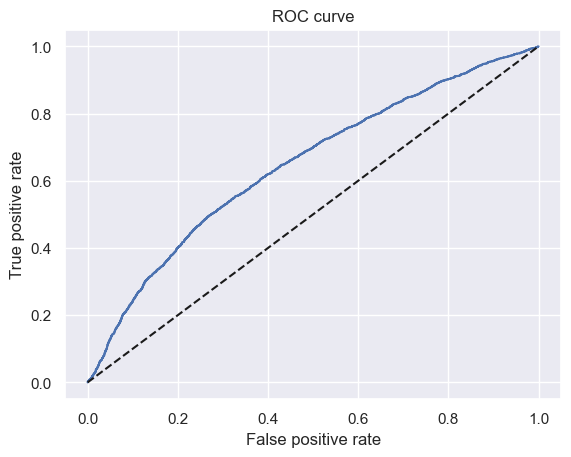

In [45]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [46]:
AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
AUROC

0.6469511779796804

### Stage 2 - Linear Regression

In [47]:
# Only focus on the case that the recovery rate is greate than 0
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [48]:
# Select only recovery rate as dependent variable
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(
    ['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [49]:
class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1, positive=False):
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs
        self.positive = positive
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [50]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[all_feature]

In [51]:
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [52]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [53]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [54]:
create_summary_table(feature_name, reg_lgd_st_2, 'Linear')

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000000e+00
2,grade:B,-5.083556e-02,0.000000e+00
3,grade:C,-3.748066e-02,0.000000e+00
4,grade:D,-2.717310e-02,1.970202e-12
5,grade:E,-1.315941e-02,1.918578e-03
6,grade:F,-5.260168e-03,2.748685e-01
7,home_ownership:MORTGAGE,2.832212e-03,6.050271e-02
8,home_ownership:NONE,1.459035e-01,9.092582e-05
9,home_ownership:OTHER,-9.475922e-03,6.436926e-01


### Linear Regression Evaluation

In [55]:
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[all_feature].drop(features_reference_cat, axis = 1)

In [56]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [57]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test

In [58]:
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [59]:
# To check the accuracy of the model
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


<Axes: xlabel='recovery_rate', ylabel='Count'>

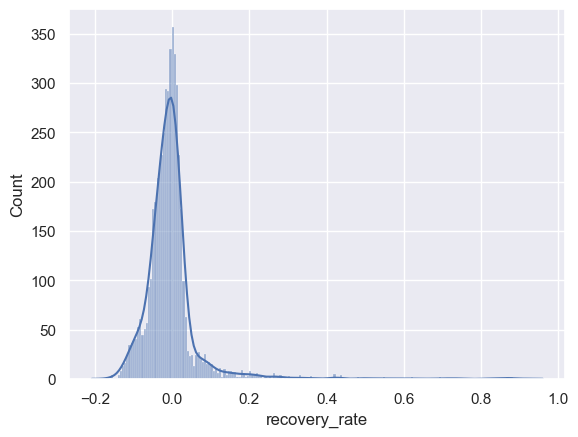

In [60]:
sns.histplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2, kde=True)

```
The model's distribution resembles a normal distribution, with most residuals symmetrically centered around 0, indicating a strong fit.
```

### Combine Stage 1 and Stage 2
* To get the combine predicted recovery rate

In [61]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)

In [62]:
y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [63]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.086545
std,0.049997
min,-0.007634
25%,0.062391
50%,0.100690
75%,0.123041
max,0.236973


```
Since Linear Regression is not constrained to produce predicted values within the [0,1] range, and the recovery rate should lie between 0 and 1, we need to adjust the values to 0 or 1.
```

In [64]:
y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, np.where(y_hat_test_lgd > 1, 1,  y_hat_test_lgd))

In [65]:
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.086547
std,0.049994
min,0.000000
25%,0.062391
50%,0.100690
75%,0.123041
max,0.236973


# EAD Model
### Estimation and Interpretation

In [66]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(
    ['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)

In [67]:
ead_inputs_train = ead_inputs_train[all_feature].drop(features_reference_cat, axis = 1)

In [68]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

In [69]:
feature_name = ead_inputs_train.columns.values

In [70]:
create_summary_table(feature_name, reg_ead, 'Linear')

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,0.000000e+00
5,grade:E,-6.768713e-02,0.000000e+00
6,grade:F,-2.045907e-02,4.428795e-03
7,home_ownership:MORTGAGE,-6.343341e-03,2.632464e-03
8,home_ownership:NONE,-5.539064e-03,9.318931e-01
9,home_ownership:OTHER,-2.426052e-03,9.335820e-01


### Model Validation

In [71]:
ead_inputs_test = ead_inputs_test[all_feature].drop(features_reference_cat, axis = 1)

In [72]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [73]:
ead_targets_test_temp = ead_targets_test.reset_index(drop = True)

In [74]:
pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis = 1).corr()

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


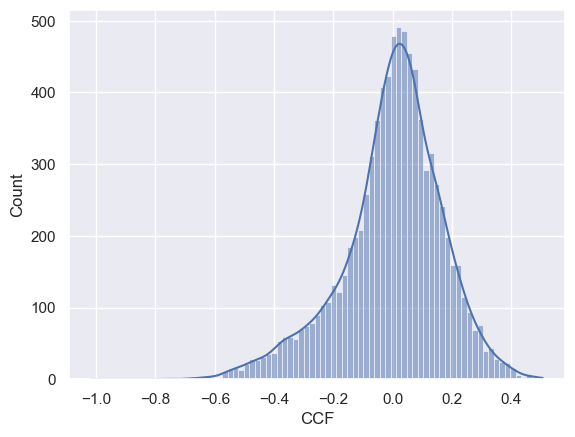

In [75]:
sns.histplot(ead_targets_test - y_hat_test_ead, kde = True)
plt.show()

```
The distribution resembles a normal distribution, with most of the residuals symmetrically distributed around 0, and the majority concentrated at 0.
```

In [76]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.736013
std,0.105194
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.161088


In [77]:
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)

In [78]:
pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


# Expected Loss
* (EL = PD * LGD * EAD)
* Banks care more about the aggregated Loss rather than a singel borrower

### LGD & EAD Model

In [79]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,0,0,0,0,0,0,1,0,1
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,0,0,0,0,0,0,1,0,0
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,0,0,0,0,0,0,1,0,1
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,0,0,0,0,0,0,1,0,1
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,0,0,0,0,0,0,1,0,1


In [80]:
cols_tofill = ['mths_since_last_delinq', 'mths_since_last_record']

fill_na_wtih_0(loan_data_preprocessed, cols_tofill)

In [81]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed[all_feature]

In [82]:
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [83]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)

In [84]:
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [85]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

In [86]:
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])

In [87]:
# Loss Given Default = 1 - recovery rate
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']

In [88]:
loan_data_preprocessed['LGD'].describe()

count    466285.000000
mean          0.921861
std           0.057642
min           0.659786
25%           0.874247
50%           0.900798
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

In [89]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

In [90]:
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])

In [91]:
# CCF is the proportion of the original loan amount that remains unpaid at the time of the borrower's default. 
# Therefore, Expected At Default (EAD) = CCF * Funded_amount.

loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed_lgd_ead['funded_amnt']

In [92]:
loan_data_preprocessed.head()

,Unnamed: 0.1,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,...,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad,recovery_rate_st_1,recovery_rate_st_2,recovery_rate,LGD,CCF,EAD
0,0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,...,0,1,0,1,1,0.086271,0.086271,0.913729,0.589922,2949.608449
1,1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,...,0,1,0,0,1,0.084518,0.084518,0.915482,0.777773,1944.433378
2,2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,...,0,1,0,1,1,0.080516,0.080516,0.919484,0.658306,1579.934302
3,3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,...,0,1,0,1,1,0.095076,0.095076,0.904924,0.660656,6606.559612
4,4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,...,0,1,0,1,1,0.088547,0.088547,0.911453,0.708211,2124.631667


### PD (Probability of Default)

In [93]:
loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')

In [94]:
# We need the data of PD model have the same rows as Loan_data_preprocessed 

loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0)

In [95]:
loan_data_inputs_pd.shape

(466285, 325)

In [96]:
# We need 'Unnamed: 0' index to match Loan_data_preprocessed

loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')

In [97]:
all_feature_pd = ['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'addr_state:NM_VA',
'addr_state:NY',
'addr_state:OK_TN_MO_LA_MD_NC',
'addr_state:CA',
'addr_state:UT_KY_AZ_NJ',
'addr_state:AR_MI_PA_OH_MN',
'addr_state:RI_MA_DE_SD_IN',
'addr_state:GA_WA_OR',
'addr_state:WI_MT',
'addr_state:TX',
'addr_state:IL_CT',
'addr_state:KS_SC_CO_VT_AK_MS',
'addr_state:WV_NH_WY_DC_ME_ID',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'initial_list_status:f',
'initial_list_status:w',
'term:36',
'term:60',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'mths_since_issue_d:<38',
'mths_since_issue_d:38-39',
'mths_since_issue_d:40-41',
'mths_since_issue_d:42-48',
'mths_since_issue_d:49-52',
'mths_since_issue_d:53-64',
'mths_since_issue_d:65-84',
'mths_since_issue_d:>84',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'mths_since_earliest_cr_line:141-164',
'mths_since_earliest_cr_line:165-247',
'mths_since_earliest_cr_line:248-270',
'mths_since_earliest_cr_line:271-352',
'mths_since_earliest_cr_line:>352',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-140K',
'annual_inc:>140K',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'mths_since_last_delinq:Missing',
'mths_since_last_delinq:0-3',
'mths_since_last_delinq:4-30',
'mths_since_last_delinq:31-56',
'mths_since_last_delinq:>=57',
'mths_since_last_record:Missing',
'mths_since_last_record:0-2',
'mths_since_last_record:3-20',
'mths_since_last_record:21-31',
'mths_since_last_record:32-80',
'mths_since_last_record:81-86',
'mths_since_last_record:>86',
]

In [98]:
ref_categories_pd = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'addr_state:ND_NE_IA_NV_FL_HI_AL',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'initial_list_status:f',
'term:60',
'emp_length:0',
'mths_since_issue_d:>84',
'int_rate:>20.281',
'mths_since_earliest_cr_line:<140',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'annual_inc:<20K',
'dti:>35',
'mths_since_last_delinq:0-3',
'mths_since_last_record:0-2']

In [99]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[all_feature_pd]

In [100]:
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [101]:
loan_data_inputs_pd_temp.shape

(466285, 84)

In [102]:
import pickle

In [103]:
# Load the PD we have saved before

reg_pd = pickle.load(open('pd_model.sav', 'rb'))

In [104]:
# Since the predict proba will give two arrays, Probability of Default and Probability of Non-Default
# but we only need the probability of Deafault in this case

reg_pd.model.predict_proba(loan_data_inputs_pd_temp)

array([[0.02526219, 0.97473781],
       [0.08468859, 0.91531141],
       [0.03538374, 0.96461626],
       ...,
       [0.02382479, 0.97617521],
       [0.03589026, 0.96410974],
       [0.04520387, 0.95479613]])

In [105]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[:, 0]

In [106]:
loan_data_inputs_pd['PD'].head()

Unnamed: 0
427211    0.025262
206088    0.084689
136020    0.035384
412305    0.173623
36159     0.211434
Name: PD, dtype: float64

In [107]:
loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.097146
std           0.069382
min           0.004656
25%           0.045698
50%           0.079450
75%           0.131306
max           0.581507
Name: PD, dtype: float64

In [108]:
loan_data_preprocessed_new =pd.concat([loan_data_preprocessed, loan_data_inputs_pd], axis = 1)

In [109]:
loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [110]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean        944.042539
std        1011.708934
min           6.820787
25%         298.380032
50%         603.919618
75%        1201.590586
max       11872.862422
Name: EL, dtype: float64

```
The average of Expected Loss per exposure is about $944
```

In [111]:
loan_data_preprocessed_new[['funded_amnt', 'PD', 'LGD', 'EAD', 'EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.161378,0.913729,2949.608449,434.936112
1,2500,2500,0.282525,0.915482,1944.433378,502.921341
2,2400,2400,0.231033,0.919484,1579.934302,335.627147
3,10000,10000,0.205175,0.904924,6606.559612,1226.624405
4,3000,3000,0.124400,0.911453,2124.631667,240.901205


In [112]:
# Banks care more about the aggregate expected loss than about the loss of a single borrower

loan_data_preprocessed_new['EL'].sum()

440192875.44448465

In [113]:
# Calculate the EL as a proportion of the total funded amount

loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.066055
funded_amnt    0.066055
dtype: float64

```
The bank typically holds 10% of its assets as capital, and the expected loss of this portfolio is less than 10%.
```